In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=1d366451f7ea33b682a332d7f86ce52cab2448f9ef8bb7903d8afda2f28eefaa
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=34300e095522ca0644c288dfe3632bd22480aacae579aace17a9d3bea95294e6
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
import numpy as np
import pandas as pd
import pydicom
import cv2
import os
import random
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold
from skimage.measure import label,regionprops
from skimage.segmentation import clear_border 
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, 
    Conv2D, AveragePooling2D, LeakyReLU, Concatenate, GlobalMaxPooling2D, GaussianNoise)
import efficientnet.tfkeras as efn

from skopt import gp_minimize, forest_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations, plot_convergence, plot_regret
from skopt.space import Categorical, Integer, Real

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# Image model

In [4]:
alpha = 0.5
weights = '../input/osictrial4/'
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 
models = [0,1,2,3,4]

COMMIT = len(os.listdir('../input/osic-pulmonary-fibrosis-progression/test/')) == 5
COMMIT

True

In [5]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')

def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
        vector.append(0)
    else:
        vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector)

A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)
    
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a
    
def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
176it [00:00, 590.38it/s]


In [6]:
def build_model(shape=(512, 512, 1), model_class=None, ml=0):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalMaxPooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = GaussianNoise(0.25)(inp2)
    x = Concatenate()([x, x2])
    x = Dropout(0.25)(x)
    x = Dense(1)(x)
    model = M.Model([inp, inp2] , x)
    
    wl = os.listdir(weights)
    wl.sort()
    
    weight = wl[:-1][ml]
    model.load_weights(weights+weight)
    
    return model

# model = build_model(model_class='b5')
# model.load_weights(weight)
# models = [model]

print('Number of models: ' + str(len(models)))

Number of models: 5


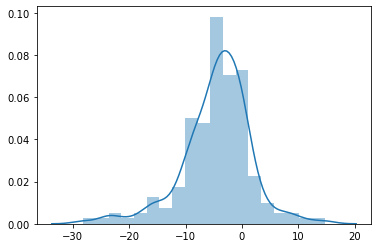

In [7]:
tr_p, vl_p = train_test_split(P, shuffle=True, train_size= 0.8)
sns.distplot(list(A.values()));

In [8]:
if not COMMIT:
    subs = []
    for n in models:
        model = build_model(shape=(512, 512, 1), model_class='b5', ml=n)
        metric = []
        for q in tqdm(range(1, 5)):
            m = []
            for p in vl_p:
                x = [] 
                tab = [] 

                if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                    continue

                ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
                for i in ldir:
                    if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                        x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                        tab.append(get_tab(train.loc[train.Patient == p, :])) 
                if len(x) < 1:
                    continue
                tab = np.array(tab) 

                x = np.expand_dims(x, axis=-1) 
                _a = model.predict([x, tab]) 
                a = np.quantile(_a, q / 5)

                percent_true = train.Percent.values[train.Patient == p]
                fvc_true = train.FVC.values[train.Patient == p]
                weeks_true = train.Weeks.values[train.Patient == p]

                fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
                percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
                m.append(score(fvc_true, fvc, percent))
            print(np.mean(m))
            metric.append(np.mean(m))

        q = (np.argmin(metric) + 1)/ 5

        sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
        test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
        A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
        STD, WEEK = {}, {} 
        for p in test.Patient.unique():
            x = [] 
            tab = [] 
            ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                    x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                    tab.append(get_tab(test.loc[test.Patient == p, :])) 
            if len(x) <= 1:
                continue
            tab = np.array(tab) 

            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q)
            A_test[p] = a
            B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
            P_test[p] = test.Percent.values[test.Patient == p] 
            WEEK[p] = test.Weeks.values[test.Patient == p]

        for k in sub.Patient_Week.values:
            p, w = k.split('_')
            w = int(w) 

            fvc = A_test[p] * w + B_test[p]
            sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
            sub.loc[sub.Patient_Week == k, 'Confidence'] = (
                P_test[p] - A_test[p] * abs(WEEK[p] - w) 
        ) 

        _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
        subs.append(_sub)

In [9]:
if not COMMIT:
    N = len(subs)
    sub = subs[0].copy()
    sub["FVC"] = 0
    sub["Confidence"] = 0
    for i in range(N):
        sub["FVC"] += subs[0]["FVC"] * (1/N)
        sub["Confidence"] += subs[0]["Confidence"] * (1/N)
        
    img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    img_sub.to_csv("submission_img.csv", index=False)
    print(img_sub)

# QR Model

In [10]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

In [11]:
# Chest Area calculations
def ChArCalc(x):
    x = pydicom.dcmread(x)
    img = x.pixel_array
    img = (img + x.RescaleIntercept) / x.RescaleSlope
    img = img < -400

    img = clear_border(img)
    img = label(img)
    areas = [r.area for r in regionprops(img)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(img):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                    img[coordinates[0], coordinates[1]] = 0

    area = (img > 0).sum() * x.PixelSpacing[0] * x.PixelSpacing[1]

    return area

def ChAr(xs):
    m = len(xs)
    path = '../input/osic-pulmonary-fibrosis-progression/train/' + xs[0].split('/')[-2] + '/'
    
    try:
        if m%2 == 0:
            m = m // 2
            char = (ChArCalc(path + str(m) + '.dcm') + ChArCalc(path + str(m+1) + '.dcm') ) / 2
        else:
            m = m // 2
            char = ( ChArCalc(path + str(m) + '.dcm') + ChArCalc(path + str(m+1) + '.dcm') + ChArCalc(path + str(m+2) + '.dcm') ) / 3
    except:
        char = -1
        
    return char

# Lung Volume Calcs
class Detector:
    def __call__(self, x):
        raise NotImplementedError('Abstract') 
        
class ThrDetector(Detector):
    def __init__(self, thr=-400):
        self.thr = thr
        
    def __call__(self, x):
        try:
            x = pydicom.dcmread(x)
            img = x.pixel_array
            img = (img + x.RescaleIntercept) / x.RescaleSlope
            img = img < self.thr
            
            img = clear_border(img)
            img = label(img)
            areas = [r.area for r in regionprops(img)]
            areas.sort()
            if len(areas) > 2:
                for region in regionprops(img):
                    if region.area < areas[-2]:
                        for coordinates in region.coords:                
                            img[coordinates[0], coordinates[1]] = 0
                            
            area = (img > 0).sum() * x.PixelSpacing[0] * x.PixelSpacing[1]
            
        except:
            area = np.nan

        try:
            loc = x.ImagePositionPatient[2]
        except:
            loc = np.nan

        return area, loc
    
class Integral:
    def __init__(self, detector: Detector):
        self.detector = detector
    
    def __call__(self, xs):
        raise NotImplementedError('Abstract')
        

class AreaIntegral(Integral):
    def __call__(self, xs):
        
        with Pool(4) as p:
            areas, locs = map(list, zip(*p.map(self.detector, xs) ))
        
        filt = (~np.isnan(locs)) & (~np.isnan(areas))
        areas = np.array(areas)[filt]
        locs = np.array(locs)[filt]
        seq_idx = np.argsort(locs)

        return np.trapz(y=areas[seq_idx], x=locs[seq_idx])
    
integral = AreaIntegral(ThrDetector())

In [12]:
tr = pd.read_csv('../input/osicaltfiles/train.csv')
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])

chunk = pd.read_csv(f"{ROOT}/test.csv")
train_data = {}
for p in chunk.Patient.values:
    train_data[p] = os.listdir(f'{ROOT}/test/{p}/')
    
keys = [k for k in list(train_data.keys()) if k not in ['ID00011637202177653955184', 'ID00052637202186188008618']]

In [13]:
%%time
mdata = {}
for k in tqdm(keys, total=len(keys)):
    x = []
    for i in train_data[k]:
        x.append(f'{ROOT}/test/{k}/{i}')
    vol = integral(x)
    char = ChAr(x)
    
    mdata[k] = [round(vol/1000,3), round(char,3)] # Volume in ml, Chest Area in mm2

100%|██████████| 5/5 [00:34<00:00,  6.97s/it]

CPU times: user 464 ms, sys: 274 ms, total: 738 ms
Wall time: 34.8 s


In [14]:
for k in tqdm(chunk.Patient.values):
    if k in ['ID00011637202177653955184', 'ID00052637202186188008618']:
        continue

    chunk.loc[chunk.Patient == k,'vol'] = mdata[k][0]
    chunk.loc[chunk.Patient == k,'char'] = mdata[k][1]
    
chunk['vol'] = chunk['vol'].clip(lower = 500, upper = 6000)
chunk.loc[chunk.char < 0,'char'] = 21500  # ~Median value in train set
chunk['char'] = chunk['char'].clip(lower = 5000, upper = 35000)

sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

100%|██████████| 5/5 [00:00<00:00, 277.36it/s]


In [15]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [16]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

(1535, 10) (5, 10) (730, 12) (2270, 12)
176 5 5 176


In [17]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [18]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [19]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [20]:
COLS = ['Sex','SmokingStatus']
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [21]:
# Height calculations
def calculate_height(row):
    if row['Sex'] == 'Male':
        return row['FirstFVC'] / (27.63 - 0.112 * row['Age'])
    else:
        return row['FirstFVC'] / (21.78 - 0.101 * row['Age'])

def fill_height(all_data):
    all_data['FirstWeek'] = all_data['Weeks']
    all_data.loc[all_data.WHERE=='test','FirstWeek'] = np.nan
    all_data['FirstWeek'] = all_data.groupby('Patient')['FirstWeek'].transform('min')

    first_fvc = (
        all_data
        .loc[all_data.Weeks == all_data.FirstWeek][['Patient','FVC']]
        .rename({'FVC': 'FirstFVC'}, axis=1)
        .groupby('Patient')
        .first()
        .reset_index()
    )

    all_data = all_data.merge(first_fvc, on='Patient', how='left')

    all_data['Height'] = all_data.apply(calculate_height, axis=1)
    return all_data

data = fill_height(data)
data['Height'] = data['Height'].clip(lower = 100, upper = 210)

In [22]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
data['vol'] = (data['vol'] - data['vol'].min() ) / ( data['vol'].max() - data['vol'].min() )
data['char'] = (data['char'] - data['char'].min() ) / ( data['char'].max() - data['char'].min() )
data['Height'] = (data['Height'] - data['Height'].min() ) / ( data['Height'].max() - data['Height'].min() )
FE = ['age','percent','vol','char','week','Height','BASE']

In [23]:
data.drop_duplicates(['Patient']).head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,vol,char,WHERE,...,Ex-smoker,Never smoked,Currently smokes,FirstWeek,FirstFVC,Height,age,BASE,week,percent
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,0.425740,0.431795,train,...,1,0,0,-4.0,2315,0.211421,0.769231,0.241456,0.179012,0.236393
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,0.695168,0.631081,train,...,1,0,0,8.0,3660,0.762737,0.512821,0.491270,0.179012,0.453901
18,ID00010637202177584971671,0,3523,94.724672,60,Male,Ex-smoker,0.301749,0.413286,train,...,1,0,0,0.0,3523,0.622582,0.282051,0.465825,0.179012,0.529881
27,ID00011637202177653955184,6,3326,85.987590,72,Male,Ex-smoker,0.526056,0.545809,train,...,1,0,0,6.0,3326,0.636261,0.589744,0.429235,0.179012,0.459572
36,ID00012637202177665765362,33,3418,93.726006,65,Male,Never smoked,0.665144,0.633342,train,...,0,1,0,33.0,3418,0.617824,0.410256,0.446322,0.179012,0.521844


In [24]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [25]:
tr.shape, chunk.shape, sub.shape

((1535, 27), (5, 27), (730, 27))

In [26]:
# For Test Label inclusion purposes
new=pd.concat([tr,chunk])
tr=new.copy()
tr.shape

(1540, 27)

Feature: 0, Score: 0.00592
Feature: 1, Score: 0.04175
Feature: 2, Score: 0.00440
Feature: 3, Score: 0.00603
Feature: 4, Score: 0.00633
Feature: 5, Score: 0.00555
Feature: 6, Score: 0.93001


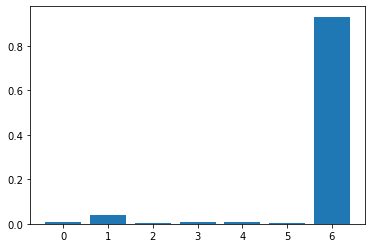

In [27]:
y = tr['FVC'].values.astype(float)
y = y.astype("float32", copy=True)
z = tr[FE].values.astype("float32")

# random forest for feature importance on a regression problem
from sklearn.ensemble import RandomForestRegressor

# define the model
model = RandomForestRegressor()
# fit the model
model.fit(z, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### BASELINE NN 

In [28]:
def log(text):
    with open('opt.log', 'a+') as logger:
        logger.write(f'{text}\n')

def calculate_final_score(y, pred,fac):
    x=fac*pred[:, 1]
    return mean_absolute_error(y, x)
        
def optimize(space, y, pred, n_calls=10):
    @use_named_args(space)
    def score(**params):
        final_score = calculate_final_score(y, pred, **params)
        return final_score

    return gp_minimize(func=score, dimensions=space, n_calls=n_calls)

In [29]:
!mkdir saves
checkpoint_path = "./saves/best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_score', 
    verbose=0,
    save_weights_only=True,
    mode='min',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_score', factor=0.5,
                              patience=25, min_lr=0.0001)

In [30]:
NFOLD = 5
train_df = tr.copy()

gkf = GroupKFold(n_splits=NFOLD)

X = train_df[['Patient', 'Weeks', 'Percent', 'Age', 'Sex', 'SmokingStatus']].values
y = train_df['FVC'].values
groups = train_df['Patient'].values

for i, (trn_, val_) in enumerate(gkf.split(X, y, groups)):
    train_df.loc[val_, 'fold'] = i

train_df['fold'] = train_df['fold'].astype(int)
#train_df

In [31]:
y = train_df['FVC'].values
z = train_df[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [32]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.4, 0.50, 0.6]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================#
def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.GaussianNoise(0.005)(z)
    x = L.Dense(100, activation="swish", name="d1")(x)
    x = L.Dropout(0.4)(x)
    x = L.GaussianNoise(0.01)(x)
    x = L.Dense(100, activation="swish", name="d2")(x)
    x = L.Dropout(0.4)(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="swish", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    
    model.compile(loss=mloss(0.5), optimizer=tf.keras.optimizers.Adam(
        lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [33]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 7)            0           Patient[0][0]                    
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          800         gaussian_noise[0][0]             
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100)          0           d1[0][0]                         
________________________________________________________________________________________________

In [34]:
train_df[FE].head()

,age,percent,vol,char,week,Height,BASE
0,0.769231,0.236393,0.42574,0.431795,0.179012,0.211421,0.241456
1,0.769231,0.215941,0.42574,0.431795,0.234568,0.211421,0.241456
2,0.769231,0.184960,0.42574,0.431795,0.246914,0.211421,0.241456
3,0.769231,0.201767,0.42574,0.431795,0.259259,0.211421,0.241456
4,0.769231,0.186580,0.42574,0.431795,0.271605,0.211421,0.241456


In [35]:
%%time

if not COMMIT:
    cnt = 0
    EPOCHS = 1000

    for fold in range(NFOLD):
        print(f"FOLD {fold}")

        tr_idx=train_df[train_df['fold']!=fold].index.values
        val_idx=train_df[train_df['fold']==fold].index.values

        net = make_model(nh)
        net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
                validation_data=(z[val_idx], y[val_idx]), callbacks= [cp_callback, reduce_lr], verbose=0) 

        net=make_model(nh)
        net.load_weights(checkpoint_path)

        print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
        print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))

        pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
        pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [36]:
%%time

OPT= True
fac= 1.0

space = [Real(0.9, 1.1, name='fac')]

if OPT and not COMMIT:
    opt_result = optimize(space, y,pred,n_calls=50)
    
    best_final_score = opt_result.fun
    best_fac = opt_result.x[0]
    print(f'[Best Factor]: {best_fac:.4f}')
    print(f'[Best Score]: {best_final_score:.6f}')

CPU times: user 1.09 ms, sys: 12 µs, total: 1.1 ms
Wall time: 1.11 ms


In [37]:
if not COMMIT:
    fac= opt_result.x[0]

    sigma_opt = mean_absolute_error(y, pred[:, 1])
    sigma_opt2 = mean_absolute_error(y, fac*pred[:, 1])
    unc = (pred[:,2] - pred[:, 0]) 
    sigma_mean = np.mean(unc)
    print(sigma_opt, sigma_mean)
    print(f'{sigma_opt2} using fac = {fac}')

In [38]:
if not COMMIT:
    idxs = np.random.randint(0, y.shape[0], 100)
    plt.plot(y[idxs], label="ground truth")
    plt.plot(pred[idxs, 0], label="q25")
    plt.plot(pred[idxs, 1], label="q50")
    plt.plot(pred[idxs, 2], label="q75")
    plt.legend(loc="best")
    plt.show()

In [39]:
if not COMMIT:
    print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())
    plt.hist(unc)
    plt.title("uncertainty in prediction")
    plt.show()

In [40]:
if not COMMIT:
    sub['FVC1'] = fac * pe[:, 1]
    sub['Confidence1'] = pe[:, 2] - pe[:, 0]
    
    subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
    subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
    if sigma_mean<70:
        subm['Confidence'] = sigma_opt
    else:
        subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']
    
    otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
    for i in range(len(otest)):
        subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
        subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1
    
    qr_sub = subm[["Patient_Week","FVC","Confidence"]].copy()
    qr_sub.to_csv("submission_qr.csv", index=False)
    print(qr_sub)

# Ensemble

In [41]:
if not COMMIT:
    df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
    df2 = qr_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
    
    df = df1[['Patient_Week']].copy()

    df['FVC'] = alpha*df1['FVC'] + (1-alpha)*df2['FVC']
    df['Confidence'] = df2['Confidence'] # alpha*df1['Confidence'] + (1-alpha)*df2['Confidence']

    df.to_csv('submission.csv', index=False)
    print(df.head())
    
else:
    !cp -r '../input/osic-pulmonary-fibrosis-progression/sample_submission.csv' 'submission.csv'